## Reproducing results from _Accurate peptide fragmentation predictions allow data driven approaches to replace and improve upon proteomics search engine scoring functions _

This notebook can be used to parse and visualize the results from _Accurate peptide fragmentation predictions allow data driven approaches to replace and improve upon proteomics search engine scoring functions _. To run this code it is assumed you ran the instructions in the wiki and have the following set of files in the current working directory:

- <file\>.pin
- <file\>.pout
- <file\>.pout_dec
- <file\>.weights

The files loaded in this notebook correspond to the _Pyrococcus furiosus_ dataset, but feel free to adapt them to other files.

The code is meant to be run in `python 3`. If using a previous version, some changes maybe necessary. First, some python packages must be imported:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF

The following function is used to calculate _q-values_ based on a distribution of target and decoy scores.

In [2]:
def calc_qval(df_in, decoy_col='Decoy', score_col='Score', better_score='higher', correct_pi_zero=True):
    if better_score == 'higher':
        sort_ascending = False
    elif better_score == 'lower':
        sort_ascending = True

    df = df_in.sort_values(score_col, ascending=sort_ascending)

    if correct_pi_zero:
        pi_zero_correction = df[decoy_col].value_counts()[False] / df[decoy_col].value_counts()[True]
    else:
        pi_zero_correction = 1
    df['decoy_cumsum'] = df[decoy_col].cumsum()
    df['target_cumsum'] = (~df[decoy_col]).cumsum()
    df['q_val'] = (df['decoy_cumsum'] / df['target_cumsum']) * pi_zero_correction

    return df['q_val'].sort_index()

Reading in the data: pin file

In [3]:
pin = pd.read_csv('pyrfu/Velos005137.pin', index_col=0, sep='\t')
pin.head()

,Label,ScanNr,spec_pearson_norm,ionb_pearson_norm,iony_pearson_norm,spec_spearman_norm,ionb_spearman_norm,iony_spearman_norm,spec_mse_norm,ionb_mse_norm,...,iony_mean_abs_diff,iony_std_abs_diff,dotprod,dotprod_ionb,dotprod_iony,cos,cos_ionb,cos_iony,Peptide,Proteins
SpecId,,,,,,,,,,,,,,,,,,,,,
303.850555419922_294.2646,-1,0,-1.336366,-1.976947,-1.293960,-1.350751,-1.821659,-1.248230,2.221810,-0.373932,...,3.029337,2.629354,-0.872721,-0.556698,-0.755130,-1.995187,-0.070981,-2.175519,X.GYKSKAVR.X,GYKSKAVR
468.268646240234_302.19520000002,1,1,0.529016,0.801825,0.430751,0.138500,0.147642,0.585054,0.233445,-0.473910,...,1.455406,2.081794,4.449631,6.774033,1.835521,0.660099,0.804108,0.748103,X.THPPKVEK.X,THPPKVEK
339.520446777344_352.58629999998,-1,2,-0.527421,-1.581583,-0.430902,-0.805813,-1.025941,-0.057507,0.447969,-0.537120,...,1.125487,1.167243,-0.616123,-0.556376,-0.449488,-1.295374,-1.879743,-1.449975,X.VKHMGGLMK.X,VKHMGGLMK
441.761352539063_367.05730000002,-1,3,-2.097717,-1.976947,-2.610272,-2.200481,-1.821659,-2.687175,2.788150,1.799402,...,1.893805,0.997729,-0.855110,-0.556698,-0.734141,-2.436831,-1.065482,-2.614511,X.PLAPASIGR.X,PLAPASIGR
455.732086181641_368.86159999998,-1,4,-1.927268,-1.976947,-2.525885,-2.365368,-1.821659,-3.126645,2.549933,0.379691,...,1.492833,0.153528,-0.848903,-0.556698,-0.726744,-2.162357,-1.649438,-2.330343,X.LEFDGTTK.X,LEFDGTTK


Reading in the data: we concatenate the target and decoy files into one large dataframe.

In [4]:
pout = pd.read_csv('pyrfu/Velos005137.pout', index_col=0, sep='\t')
pout['decoy'] = [False] * len(pout)

pout_dec = pd.read_csv('pyrfu/Velos005137.pout_dec', index_col=0, sep='\t')
pout_dec['decoy'] = [True] * len(pout_dec)

pout = pd.concat([pout, pout_dec])

pout.head()

,score,q-value,posterior_error_prob,peptide,proteinIds,decoy
PSMId,,,,,,
357.219268798828_2185.5429,7.98329,0.000139,1.175940e-19,X.RLDLVNALR.X,RLDLVNALR,False
565.253662109375_510.17119999998,7.24439,0.000139,6.925110e-18,X.SGHMGASPETR.X,SGHMGASPETR,False
565.256652832031_501.42259999998,5.17981,0.000139,6.111090e-13,X.SGHMGASPETR.X,SGHMGASPETR,False
863.98291015625_4216.6422,5.01540,0.000139,1.513460e-12,X.ILLLLGGPDVYWDPR.X,ILLLLGGPDVYWDPR,False
511.239349365234_2314.95079999998,4.53219,0.000139,2.175220e-11,X.YLGWDDPR.X,YLGWDDPR,False


Merging the two files into one large dataframe:

In [5]:
df = pd.merge(pin, pout, left_index=True, right_index=True)
df.head()

,Label,ScanNr,spec_pearson_norm,ionb_pearson_norm,iony_pearson_norm,spec_spearman_norm,ionb_spearman_norm,iony_spearman_norm,spec_mse_norm,ionb_mse_norm,...,cos_ionb,cos_iony,Peptide,Proteins,score,q-value,posterior_error_prob,peptide,proteinIds,decoy
303.850555419922_294.2646,-1,0,-1.336366,-1.976947,-1.293960,-1.350751,-1.821659,-1.248230,2.221810,-0.373932,...,-0.070981,-2.175519,X.GYKSKAVR.X,GYKSKAVR,-2.192570,0.093325,0.820768,X.GYKSKAVR.X,GYKSKAVR,True
468.268646240234_302.19520000002,1,1,0.529016,0.801825,0.430751,0.138500,0.147642,0.585054,0.233445,-0.473910,...,0.804108,0.748103,X.THPPKVEK.X,THPPKVEK,1.943710,0.000139,0.000035,X.THPPKVEK.X,THPPKVEK,False
339.520446777344_352.58629999998,-1,2,-0.527421,-1.581583,-0.430902,-0.805813,-1.025941,-0.057507,0.447969,-0.537120,...,-1.879743,-1.449975,X.VKHMGGLMK.X,VKHMGGLMK,-0.689813,0.037369,0.820768,X.VKHMGGLMK.X,VKHMGGLMK,True
441.761352539063_367.05730000002,-1,3,-2.097717,-1.976947,-2.610272,-2.200481,-1.821659,-2.687175,2.788150,1.799402,...,-1.065482,-2.614511,X.PLAPASIGR.X,PLAPASIGR,-1.863820,0.085798,0.820768,X.PLAPASIGR.X,PLAPASIGR,True
455.732086181641_368.86159999998,-1,4,-1.927268,-1.976947,-2.525885,-2.365368,-1.821659,-3.126645,2.549933,0.379691,...,-1.649438,-2.330343,X.LEFDGTTK.X,LEFDGTTK,-1.922310,0.087372,0.820768,X.LEFDGTTK.X,LEFDGTTK,True


Since in the current files there isn't any information pertaining the original search, the plots below reflect only the performance of the new score in separating target and decoy PSMs.

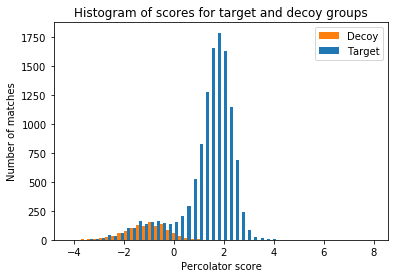

In [6]:
# Score distribution

plot_list = [list(x) for x in [df[df['decoy']]['score'], df[~df['decoy']]['score']]]
plt.hist(plot_list, bins=50, label=['Decoy', 'Target'], color=[sns.color_palette()[1], sns.color_palette()[0]], lw=1, rwidth=1)

plt.ylabel("Number of matches")
plt.xlabel('Percolator score')
plt.legend()
plt.title('Histogram of scores for target and decoy groups')

plt.show()

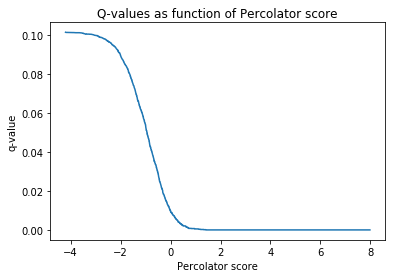

In [7]:
plt.plot(df.sort_values('score')['score'], df.sort_values('score')['q-value'])

plt.ylabel('q-value')
plt.xlabel('Percolator score')

plt.title('Q-values as function of Percolator score')

plt.show()

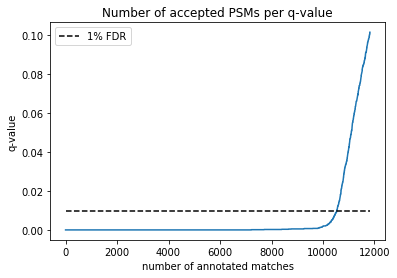

In [8]:
df = df.sort_values('q-value', ascending=True)
df['count'] = (~df['decoy']).cumsum()

plt.plot(df['count'], df['q-value'], label='_nolegend_')
plt.plot(np.linspace(0,np.max(df['count']),2), [0.01]*2, linestyle='--', color='black', label='1% FDR')

plt.xlabel('number of annotated matches')
plt.ylabel('q-value')
plt.legend()

plt.title('Number of accepted PSMs per q-value')

plt.show()

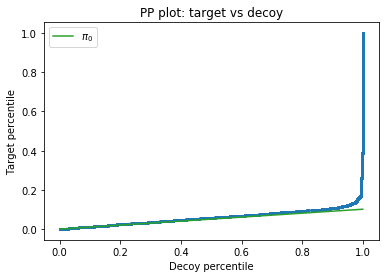

In [9]:
ratio = df['decoy'].value_counts()[True] / df['decoy'].value_counts()[False]
Ft = ECDF(df[~df['decoy']]['score'])
Fd = ECDF(df[df['decoy']]['score'])
x = df[~df['decoy']]['score']
Fdp = Fd(x)
Ftp = Ft(x)

plt.scatter(Fdp, Ftp, s=4)
plt.plot((0,1), (0, ratio), color=sns.color_palette()[2], label=r'$\pi_0$')

plt.legend()
plt.xlabel('Decoy percentile')
plt.ylabel('Target percentile')

plt.title('PP plot: target vs decoy')
plt.show()

### Visualizing feature weights

If you are interested in better understanding the scoring function that Percolator defines, you can inspect the weights file. Below is a simple visualization of the file.

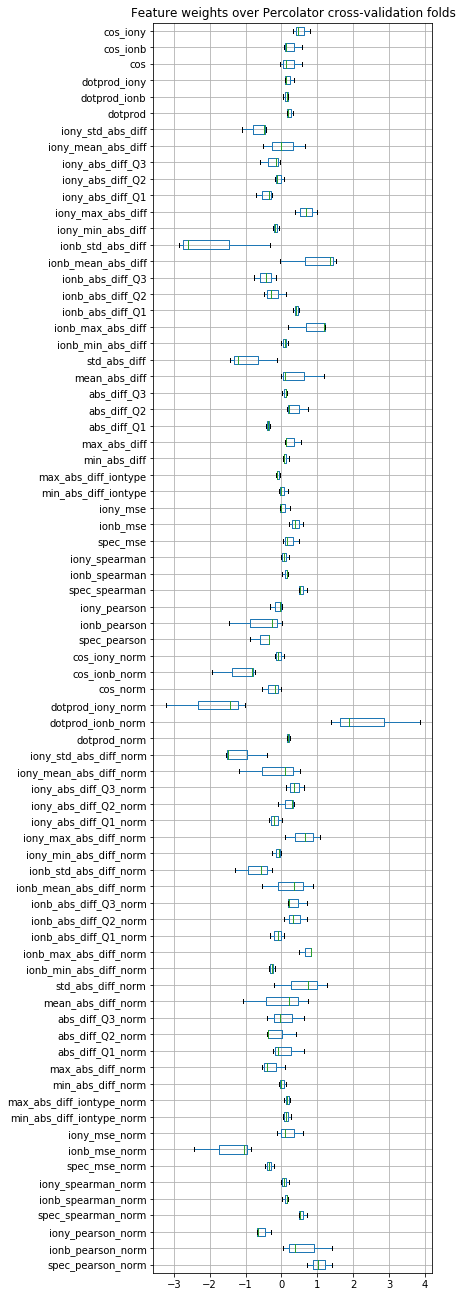

In [10]:
w = pd.read_csv('pyrfu/Velos005137.weights', sep='\t')
plt.figure(figsize=(5,23))
w = w.drop([1,2,4,5,7])
w = w.astype(float)
w.iloc[:, :-1].boxplot(vert=False)

plt.title('Feature weights over Percolator cross-validation folds')
plt.show()